Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
%%capture
! pip install git+https://github.com/LegrandNico/metadPy.git

In [2]:
import os
import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from metadPy.utils import trials2counts
from metadPy.sdt import dprime

# Preprocessing

In [3]:
parent = os.path.join(os.getcwd(), os.pardir)
path = os.path.join(os.path.abspath(parent), 'Data', 'Raw')
subjects = [f for f in os.listdir(path) if len(f) == 5]

Extract confidence, response time, d prime and average accuracy and save in the `final_df` variable.

Extrac nR_S1 and nR_S2 vector for hierarchical bayesian estimation and save in the `metacog.txt` file.

During etraction, the following rules are applied to remove outliers, either in the trial or participant level:

* Trials with RTs faster than 100ms.

* Trial with RTs greater than 3 standard deviations than the median RT value.

In [4]:
final_df, metacog_df = pd.DataFrame([]), pd.DataFrame([])

for nSub in subjects:

    # Find files name
    for file in os.listdir(os.path.join(path, nSub)):
        if file.endswith(".txt") & file.startswith('Subject') & ('Block' not in file):
            df = pd.read_csv(os.path.join(path, nSub, file), na_values=['Nan'])

    # Start loop
    for val in ['High', 'Low']:

        for aro in ['High', 'Low']:
            
            for learningTime in [30, 60, 90]:
            
                # Filter for subject and conditions
                this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val) & (df.LearningTime == learningTime)]

                # Remove NaN values
                this_df = this_df[~((this_df.RT.isnull() | this_df.Confidence.isnull()))]

                # Drop fast RT
                this_df = this_df[(this_df.RT > .1)]

                # Reject slow trials median + 3 std
                this_df = this_df[this_df.RT < (this_df.RT.median() + (3 * this_df.RT.std()))]

                # Check enough trials remain
                if len(this_df)<10:
                    raise ValueError

                #########
                # Metrics
                #########

                # Response time
                rt = this_df.RT.median()

                # Accuracy
                acc = (this_df.KeyPressed == this_df.Expected).mean()

                # Confidence
                conf = this_df.Confidence[~this_df.RT.isnull()].mean()

                # Extrac nR_S1 and nR_S2 vector and save separately
                stimID = this_df.Expected == 'right'
                responses = this_df.KeyPressed == 'right'
                confidence = this_df.Confidence
                nRatings = 7
                nR_S1, nR_S2 = trials2counts(stimuli=stimID, responses=responses, confidence=confidence, nRatings=nRatings)

                metacog_df = metacog_df.append(pd.DataFrame({'Subject': nSub,
                               'Valence': val,
                               'Arousal': aro,
                               'LearningTime': learningTime,
                               'nR_S1': nR_S1,
                               'nR_S2': nR_S2,
                               'bins': np.arange(0, 14)}), ignore_index=True)

                final_df = final_df.append(pd.DataFrame({'Subject': [nSub],
                                                         'Valence': [val],
                                                         'Arousal': [aro],
                                                         'LearningTime': [learningTime],
                                                         'Confidence': [conf],
                                                         'RT': [rt],
                                                         'Keep': [len(this_df)/150],
                                                         'Accuracy': [acc]}), ignore_index=True)

out_path = os.path.join(os.path.abspath(parent), 'Data', 'Preprocessed', 'metacog_LearningTime.txt')
metacog_df.to_csv(out_path)

Here, we use the `metad-LearningTime.R` to fit hierarchical bayesian estimation of meta d' following the method described in:

    Fleming, S. M. (2017). HMeta-d: hierarchical Bayesian estimation of metacognitive efficiency from confidence ratings. *Neuroscience of Consciousness, 2017(1)*.

This script will save the results in `metadprim_LearningTime.txt`.

In [5]:
# Merge to final_df
metadprime_df = pd.read_csv(os.path.join(os.path.abspath(parent), 'Data', 'Preprocessed', 'metadprime_LearningTime.txt'), sep='\t')
metadprime_df.Subject = metadprime_df.Subject.astype(str)
final_df = pd.merge(final_df, metadprime_df, on=['Subject', 'Valence', 'Arousal', 'LearningTime'])

Because each condition is now splitted in term of learning time (30, 60 or 90), the nuber of trials do no allow to efficiently control for the same outliers criteria than the 2x2 interaction model described in `1 - Behavioural.ipynb`.

* Participants whose values for d', confidence and response time on any condition are greater than 1.5 times the interquartile range.

In [17]:
reject = []
for metric in ['dPrime']:
    for val in ['High', 'Low']:
        for aro in ['High', 'Low']:
            for learningTime in [30, 60, 90]:
                this_df = final_df.copy().groupby(['Subject', 'Valence', 'Arousal'], as_index=False).mean()
                this_df = this_df[(this_df.Valence == val) & (this_df.Arousal == aro)]

                for sub in this_df.Subject[this_df[metric] < this_df[metric].quantile(.25) - ((q3 - q1) * 1.5)]:
                    print(sub + ' - ' + metric)
                    reject.append(sub)

11119 - RT
11119 - RT
11119 - RT
11138 - dPrime
11138 - dPrime
11138 - dPrime
11124 - dPrime
11141 - dPrime
11131 - dPrime
11124 - dPrime
11141 - dPrime
11131 - dPrime
11124 - dPrime
11141 - dPrime
11131 - dPrime
11124 - dPrime
47617 - dPrime
11124 - dPrime
47617 - dPrime
11124 - dPrime
47617 - dPrime


In [18]:
# Create reject vector
final_df['Reject'] = 0
for sub in reject:
    final_df.loc[final_df.Subject == sub, 'Reject'] = 1

Reject outliers

In [20]:
final_df = final_df[final_df.Reject!=1]

Save dataframe

In [6]:
final_df.to_csv(os.path.join(os.path.abspath(parent), 'Data', 'Preprocessed', 'Behaviour_LearningTime.txt'))

Save as JASP format

In [61]:
jasp_df = []
for metric in ['RT', 'Criterion', 'Accuracy', 'Confidence', 'dPrime', 'MetadPrime', 'Mratio']:
    this_df = final_df.copy().pivot_table(index='Subject', columns=['Valence', 'Arousal', 'LearningTime'], values=metric).reset_index()
    cols = ['Subject']
    cols.extend([''.join((metric + '_', col[1], '_Aro_', col[0], 'Val_Time', str(col[2]))) for col in this_df.columns[1:]])
    this_df.columns = cols
    jasp_df.append(this_df)
jasp_df = pd.concat(jasp_df, axis=1)
jasp_df = jasp_df.loc[:,~jasp_df.columns.duplicated()]
jasp_df.to_csv(os.path.join(os.path.abspath(parent), 'Data', 'Preprocessed', 'JASP', 'behavior_learningTime.txt'))

The statistical analyses reported in the Supplementary Material are carried out using JASP, based on the data frames saved in the previous step. Here, we provide code snippets for interactive visualization and testing directly inside Binder. Because the Pingouin package does not support repeated measure ANOVA with 3 or more factor, we simply report the result of ANOVA testing for `LearningTime` and `Valence`. Please refer to the Supplementary Material for the complete report.

# Results

Compute % of drop.

In [23]:
((1 - final_df.Keep) * 100).mean(), ((1 - final_df.Keep) * 100).std()

(67.81992337164756, 1.5951452105028563)

## Response time

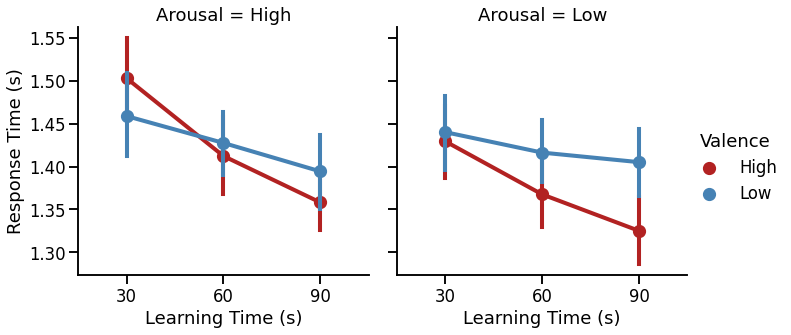

In [65]:
sns.set_context('talk')
g = sns.catplot(x="LearningTime", y="RT", hue="Valence", col="Arousal", data=final_df,
                height=5, aspect=1., kind='point', palette=['firebrick', 'steelblue'], ci=68)
g.set_axis_labels('Learning Time (s)', 'Response Time (s)')
plt.savefig(os.path.abspath(parent) + '/Figures/LearningTime_RT.png', dpi=600)

In [21]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'LearningTime'], dv='RT')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.031456,1,34,0.031456,3.205395,0.082304,0.082304,0.086154,1.000000
1,LearningTime,0.268170,2,68,0.134085,6.968532,0.001766,0.002666,0.170095,0.893746
2,Valence * LearningTime,0.050315,2,68,0.025158,3.835330,0.026410,0.026891,0.101369,0.988695


# Criterion

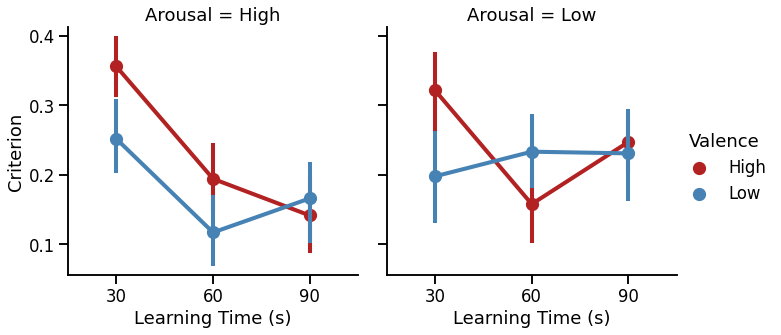

In [66]:
sns.set_context('talk')
g = sns.catplot(x="LearningTime", y="Criterion", hue="Valence", col="Arousal", data=final_df,
                height=5, aspect=1., kind='point', palette=['firebrick', 'steelblue'], ci=68)
g.set_axis_labels('Learning Time (s)', 'Criterion')
plt.savefig(os.path.abspath(parent) + '/Figures/LearningTime_Criterion.png', dpi=600)

In [23]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'LearningTime'], dv='Criterion')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.071578,1,34,0.071578,1.764268,0.192941,0.192941,0.049330,1.000000
1,LearningTime,0.442931,2,68,0.221465,3.643703,0.031387,0.037229,0.096794,0.883160
2,Valence * LearningTime,0.156083,2,68,0.078041,4.289090,0.017609,0.018992,0.112019,0.960645


# Accuracy

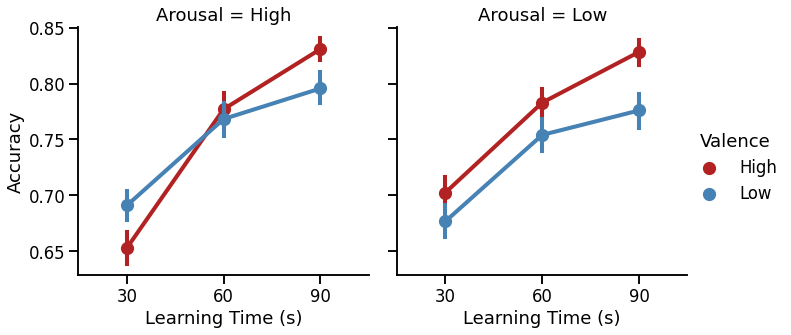

In [67]:
sns.set_context('talk')
g = sns.catplot(x="LearningTime", y="Accuracy", hue="Valence", col="Arousal", data=final_df,
                height=5, aspect=1., kind='point', palette=['firebrick', 'steelblue'], ci=68)
g.set_axis_labels('Learning Time (s)', 'Accuracy')
plt.savefig(os.path.abspath(parent) + '/Figures/LearningTime_Accuracy.png', dpi=600)

In [25]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'LearningTime'], dv='Accuracy')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.018520,1,34,0.018520,7.348264,1.044568e-02,1.044568e-02,0.177716,1.000000
1,LearningTime,0.594183,2,68,0.297092,81.623513,8.447217e-19,1.966827e-17,0.705942,0.916832
2,Valence * LearningTime,0.021728,2,68,0.010864,4.819880,1.102658e-02,1.110006e-02,0.124160,0.997117


# Confidence

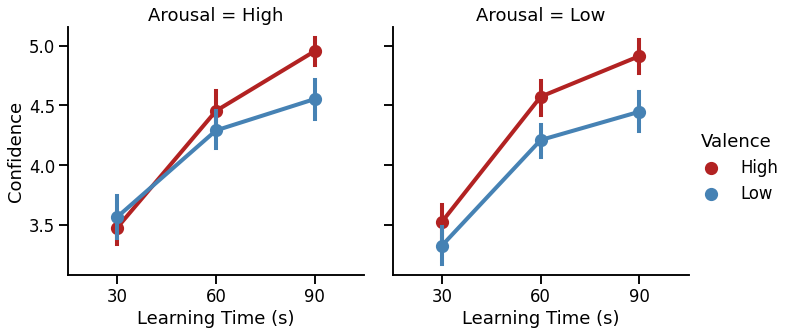

In [68]:
sns.set_context('talk')
g = sns.catplot(x="LearningTime", y="Confidence", hue="Valence", col="Arousal", data=final_df,
                height=5, aspect=1., kind='point', palette=['firebrick', 'steelblue'], ci=68)
g.set_axis_labels('Learning Time (s)', 'Confidence')
plt.savefig(os.path.abspath(parent) + '/Figures/LearningTime_Confidence.png', dpi=600)

In [67]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'LearningTime'], dv='Confidence')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,3.199460,1,28,3.199460,15.860109,4.404142e-04,4.404142e-04,0.361607,1.000000
1,LearningTime,47.724714,2,56,23.862357,59.753231,1.285457e-14,1.852156e-12,0.680923,0.825340
2,Valence * LearningTime,0.955615,2,56,0.477808,3.822078,2.779880e-02,2.813893e-02,0.120108,0.992235


# D prime

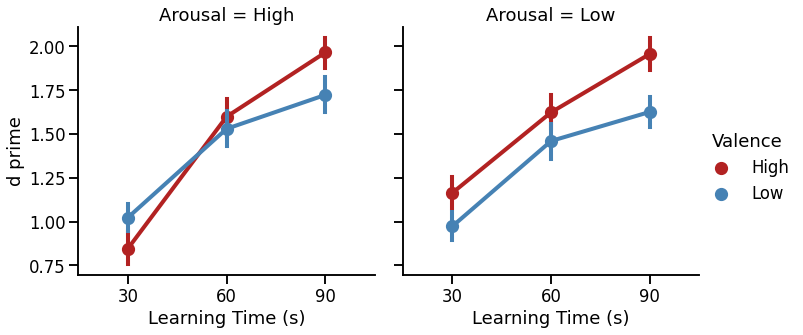

In [69]:
sns.set_context('talk')
g = sns.catplot(x="LearningTime", y="dPrime", hue="Valence", col="Arousal", data=final_df,
                height=5, aspect=1., kind='point', palette=['firebrick', 'steelblue'], ci=68)
g.set_axis_labels('Learning Time (s)', 'd prime')
plt.savefig(os.path.abspath(parent) + '/Figures/LearningTime_dPrime.png', dpi=600)

In [30]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'LearningTime'], dv='dPrime')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.978821,1,34,0.978821,9.342555,4.338770e-03,4.338770e-03,0.215552,1.000000
1,LearningTime,24.275789,2,68,12.137895,74.556527,7.210762e-18,2.966902e-17,0.686799,0.960402
2,Valence * LearningTime,0.697069,2,68,0.348535,2.968642,5.806897e-02,5.901315e-02,0.080302,0.983719


# Meta-d'

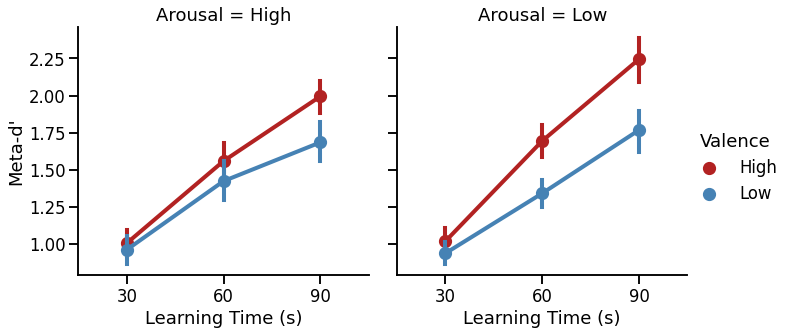

In [72]:
sns.set_context('talk')
g = sns.catplot(x="LearningTime", y="MetadPrime", hue="Valence", col="Arousal", data=final_df,
                height=5, aspect=1., kind='point', palette=['firebrick', 'steelblue'], ci=68)
g.set_axis_labels('Learning Time (s)', 'Meta-d\'')
plt.savefig(os.path.abspath(parent) + '/Figures/LearningTime_MetadPrime.png', dpi=600)

In [33]:
pg.rm_anova(data=metadprime_df, subject='Subject', within=['Valence', 'LearningTime'], dv='MetadPrime')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,2.863794,1,34,2.863794,15.979280,3.262356e-04,3.262356e-04,0.319718,1.000000
1,LearningTime,31.176754,2,68,15.588377,94.418055,2.382299e-20,8.317515e-18,0.735240,0.858524
2,Valence * LearningTime,0.960988,2,68,0.480494,3.500551,3.572755e-02,4.152000e-02,0.093347,0.889495


# M ratio

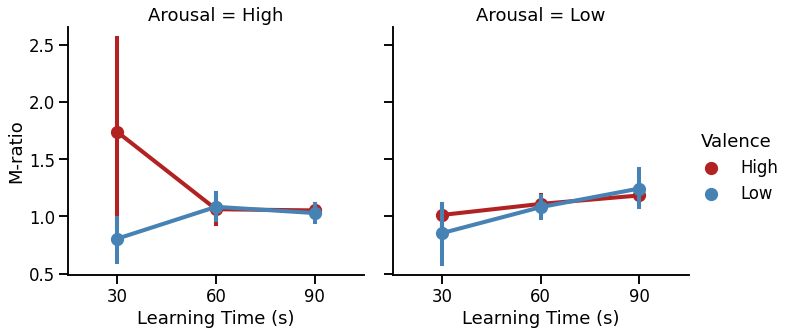

In [73]:
sns.set_context('talk')
g = sns.catplot(x="LearningTime", y="Mratio", hue="Valence", col="Arousal", data=final_df,
                height=5, aspect=1., kind='point', palette=['firebrick', 'steelblue'], ci=68)
g.set_axis_labels('Learning Time (s)', 'M-ratio')
plt.savefig(os.path.abspath(parent) + '/Figures/LearningTime_MRatio.png', dpi=600)

In [35]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'LearningTime'], dv='Mratio')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,1.641448,1,34,1.641448,2.070188,0.159346,0.159346,0.057393,1.000000
1,LearningTime,0.065078,2,68,0.032539,0.026748,0.973617,0.893026,0.000786,0.556203
2,Valence * LearningTime,3.574994,2,68,1.787497,1.235729,0.297066,0.279211,0.035070,0.560097
